In [1]:
import os
from pathlib import Path
from itertools import islice
import gzip
import pickle

import numpy as np
import matplotlib.pyplot as plt

from bokeh.io import push_notebook, show, output_notebook, output_file
from bokeh.plotting import figure, ColumnDataSource, save
from bokeh.transform import linear_cmap
from bokeh.palettes import Plasma11, Viridis11
from bokeh.util.hex import hexbin
from bokeh.layouts import gridplot
output_notebook()

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

from ei import *

Loading BokehJS ...

# Let's first replicate the simplest plot in the paper

In [2]:
singleton = nn.Linear(1, 1, bias=False)
top = topology_of(singleton, torch.zeros((1, 1)))

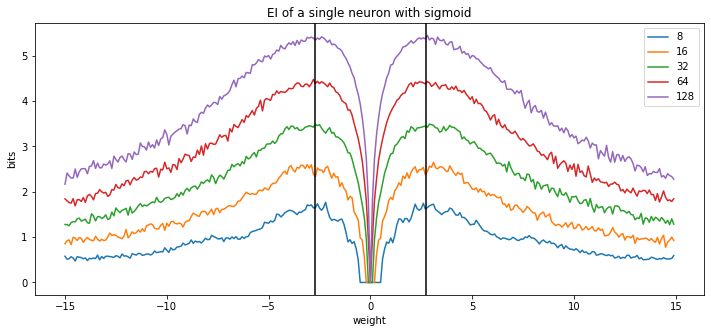

In [3]:
plt.figure(figsize=(12, 5))

ws = np.arange(-15, 15, 0.1)
for b in [8, 16, 32, 64, 128]:
    eis = []
    for w in ws:
        singleton.weight.data[0][0] = w
        eis.append(EI_of_layer(singleton, top, samples=1000, bins=b, activation=torch.sigmoid))
    plt.plot(ws, eis, label=str(b))
    
plt.axvline(np.e, color='black')
plt.axvline(-np.e, color='black')

plt.title("EI of a single neuron with sigmoid")
plt.xlabel("weight")
plt.ylabel("bits")
plt.legend()

# Now for seeing how it evolves:

In [4]:
dir_path = Path().absolute()
dataset_path = dir_path.parent.parent / "data/mnist.pkl.gz"
if not dataset_path.exists():
    print('Downloading dataset with curl ...')
    if not dataset_path.parent.exists():
        os.mkdir(dataset_path.parent)
    url = 'http://ericjmichaud.com/downloads/mnist.pkl.gz'
    os.system('curl -L {} -o {}'.format(url, dataset_path))
print('Download failed') if not dataset_path.exists() else print('Dataset acquired')
f = gzip.open(dataset_path, 'rb')
mnist = pickle.load(f)
f.close()
print('Loaded data to variable `mnist`')

Dataset acquired
Loaded data to variable `mnist`


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# dtype = torch.cuda.float if torch.cuda.is_available() else torch.float
dtype = torch.float32
torch.set_default_dtype(dtype)

print(f"Using device: {device}")

Using device: cpu


In [6]:
# ///////////////////////////////////////////
#               DEFINE `Dataset`
# ///////////////////////////////////////////
class MNISTDataset(Dataset):
    """MNIST Digits Dataset."""
    def __init__(self, data, transform=None):
        """We save the dataset images as torch.tensor since saving 
        the dataset in memory inside a `Dataset` object as a 
        python list or a numpy array causes a multiprocessiing-related 
        memory leak."""
        self.images, self.labels = zip(*data)
        self.images = torch.from_numpy(np.array(self.images)).to(dtype)
#         self.labels = torch.tensor(np.argmax(self.labels, axis=1)).to(torch.long)
        self.labels = torch.tensor(self.labels).to(dtype)
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image, label = self.images[idx], self.labels[idx]
        if self.transform:
            image, label = self.transform((image, label))
        return image, label

In [7]:
class SoftmaxRegression(nn.Module):
    """Single-layer softmax network."""
    def __init__(self, n_in, n_out):
        super(SoftmaxRegression, self).__init__()
        self.linear = nn.Linear(n_in, n_out, bias=False)
    
#     def forward(self, x):
#         return F.log_softmax(self.linear(x), dim=1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))


In [12]:
train_data = MNISTDataset(mnist[:60000])
test_data = MNISTDataset(mnist[60000:])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=20, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=20, shuffle=True)

In [13]:
model = SoftmaxRegression(28*28, 10).to(device)
# loss_fn = nn.NLLLoss()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [14]:
top = topology_of(model, next(iter(test_loader))[0].to(device))
top

{Linear(in_features=784, out_features=10, bias=False): ((20, 784), (20, 10))}

In [16]:
# --- MATPLOTLIB DATA ---
# num_batches_data = []
# eis_data = []
# losses_data = [] #[(train, test), (train, test), ...]
# accuracies_data = []


# --- DEFINE BOKEH OUTPUT ---

source = ColumnDataSource(data={
    'num_batches': [],
    'accuracy': [],
    'training_loss': [],
    'test_loss': [],
    'EI': []
})

accuracy_plot = figure(plot_width=800, plot_height=150, 
                       x_axis_label='batches', title='Accuracy')
loss_plot = figure(plot_width=800, plot_height=150, 
                       x_axis_label='batches', title='Loss')
EI_plot = figure(plot_width=800, plot_height=150,
                x_axis_label='batches', y_axis_label='bits', title='Effective Information')

accuracy_plot.line('num_batches', 'accuracy', source=source, line_width=2, color='orange')
loss_plot.line('num_batches', 'test_loss', source=source, line_width=2, color='red')
loss_plot.line('num_batches', 'training_loss', source=source, line_width=2, color='green')
EI_plot.line('num_batches', 'EI', source=source, line_width=2)

grid = gridplot([[accuracy_plot], [loss_plot], [EI_plot]])
display = show(grid, notebook_handle=True)

def update_metrics():
    with torch.no_grad():
        EI = EI_of_layer(model.linear, top, samples=100, batch_size=20, bins=16, device=device)
    
    outof = 0
    loss = 0
    with torch.no_grad():
        for x, labels in islice(test_loader, 0, 500): # 500 batches of 20 samples
            output = model(x.to(device))
            loss += loss_fn(output, labels.to(device)).item()
            _, pred = torch.max(output, 1)
            outof += len(labels)
    test_loss = loss / outof
    
    outof = 0
    loss = 0
    with torch.no_grad():
        for x, labels in islice(train_loader, 0, 500): # 500 batches of 20 samples
            output = model(x.to(device))
            loss += loss_fn(output, labels.to(device)).item()
            _, pred = torch.max(output, 1)
            outof += len(labels)
    training_loss = loss / outof
    
    outof = 0
    accuracy = 0
    with torch.no_grad():
        for x, labels in test_loader:
            output = model(x.to(device))
            _, pred = torch.max(output, 1)
            _, labels = torch.max(labels, 1)
            accuracy += (pred == labels.to(device)).sum().item()
            outof += len(labels)
    accuracy = accuracy / outof
    
    source.stream({
        'num_batches': [num_batches],
        'accuracy': [accuracy],
        'training_loss': [training_loss],
        'test_loss': [test_loss],
        'EI': [EI]
    })
    push_notebook(handle=display)
    
#     num_batches_data.append(num_batches)
#     eis_data.append(EI)
#     losses_data.append((training_loss, test_loss))
#     accuracies_data.append(accuracy)
    
#     if num_batches % 1500 == 0:
#         print("Epoch: {:3d} | EI: {:2.3f} | Accuracy: {:0.3f}".format(epoch, EI, accuracy))
    
# --- TRAIN ---

num_batches = 0
for epoch in range(20):
    for sample, target in train_loader:
        optimizer.zero_grad()
        loss = loss_fn(model(sample.to(device)), target.to(device))
        loss.backward()
        optimizer.step()
        num_batches += 1
        if num_batches % 100 == 0:
            update_metrics()

KeyboardInterrupt: 